In [17]:
import ismrmrd
import rtoml
import os
import fnmatch
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pyfftw
from pathlib import Path
import copy


# Read config
with open('config.toml', 'r') as cf:
    cfg = rtoml.load(cf)

DATA_ROOT = cfg['DATA_ROOT']
DATA_DIR = cfg['data_folder']
raw_file = cfg['raw_file']
prewhiten = cfg['editer']['prewhiten']
autoselect = cfg['editer']['autosniffer_select']
remove_os = cfg['saving']['remove_os']

data_dir_path = os.path.join(DATA_ROOT, DATA_DIR, 'raw/h5')
if raw_file.isnumeric():
    raw_file_ = fnmatch.filter(os.listdir(data_dir_path), f'meas_MID*{raw_file}*.h5')[0]
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file_)
    ismrmrd_noise_fullpath = os.path.join(DATA_ROOT, DATA_DIR, 'raw/noise', f'noise_{raw_file_}')
elif raw_file.startswith('meas_MID'):
    raw_file_ = raw_file
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file)
else:
    print('Could not find the file. Exiting...')
    exit(-1)


In [18]:
# Read the data in
print(f'Reading {ismrmrd_data_fullpath}...')
with ismrmrd.Dataset(ismrmrd_data_fullpath) as dset:

    n_acq = dset.number_of_acquisitions()
    print(f'There are {n_acq} acquisitions in the file. Reading...')

    acq_list = []
    for ii in range(n_acq):
        acq_list.append(dset.read_acquisition(ii))

    n_wf = dset.number_of_waveforms()
    print(f'There are {n_wf} waveforms in the dataset. Reading...')

    wf_list = []
    for ii in range(n_wf):
        wf_list.append(dset.read_waveform(ii))
    
    hdr = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())

# get the k-space trajectory based on the metadata hash.
traj_name = hdr.userParameters.userParameterString[1].value

# load the .mat file containing the trajectory
traj = loadmat(os.path.join(DATA_ROOT, DATA_DIR, traj_name), squeeze_me=True)

n_unique_angles = int(traj['param']['repetitions'])

kx = traj['kx'][:,:]
ky = traj['ky'][:,:]
dt = float(traj['param']['dt'])
msize = int(10 * traj['param']['fov'] / traj['param']['spatial_resolution'])
pre_discard = int(traj['param']['pre_discard'])
w = traj['w']

# Convert raw data and trajectory into convenient arrays
ktraj = np.stack((kx, -ky), axis=2)
# find max ktraj value
kmax = np.max(np.abs(kx + 1j * ky))
# swap 0 and 1 axes to make repetitions the first axis (repetitions, interleaves, 2)
ktraj = np.swapaxes(ktraj, 0, 1)
ktraj = 0.5 * (ktraj / kmax) * msize

data = [arm.data[:,:] for arm in acq_list]
dcf = np.tile(w[None, :], (n_acq, 1))
coord = [ktraj[ii%n_unique_angles,:,:] for ii in range(n_acq)]

data = np.array(data)
data = np.transpose(data, axes=(2, 0, 1))
coord = np.array(coord, dtype=np.float32)
coord = np.transpose(coord, axes=(2, 1, 0))


Reading /server/home/btasdelen/MRI_DATA/pilottone/vol0912_20240626/raw/h5/meas_MID00292_FID16401_pulseq2D_fire_spiralga_1500mV_24MHz.h5...
There are 14400 acquisitions in the file. Reading...
There are 4431 waveforms in the dataset. Reading...


Reading /server/home/btasdelen/MRI_DATA/pilottone/vol0912_20240626/raw/noise/noise_meas_MID00292_FID16401_pulseq2D_fire_spiralga_1500mV_24MHz.h5...
There are 1842 acquisitions in the file. Reading...
Prewhitening the raw data...


/server/home/btasdelen/miniforge3/envs/pilottone/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


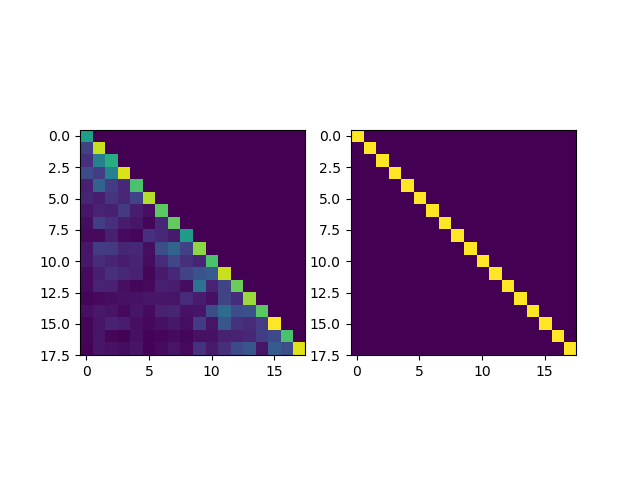

In [19]:
# Read the noise data in
print(f'Reading {ismrmrd_noise_fullpath}...')
with ismrmrd.Dataset(ismrmrd_noise_fullpath) as dset_noise:
    n_cal_acq = dset_noise.number_of_acquisitions()
    print(f'There are {n_cal_acq} acquisitions in the file. Reading...')

    cal_list = []
    for ii in range(n_cal_acq):
        cal_list.append(dset_noise.read_acquisition(ii))

noise_list = []

for cal_ in cal_list:
    if cal_.is_flag_set(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        noise_list.append(cal_.data)

noise = np.transpose(np.asarray(noise_list), (1,0,2)).reshape((noise_list[0].shape[0], -1))

if prewhiten:
    from reconstruction.coils import apply_prewhitening, calculate_prewhitening

    print('Prewhitening the raw data...')
    dmtx = calculate_prewhitening(noise)

    data = apply_prewhitening(np.transpose(data, (2,0,1)), dmtx).transpose((1,2,0))

    dmtx2 = calculate_prewhitening(apply_prewhitening(noise, dmtx))

    _,axs = plt.subplots(1,2)
    axs[0].imshow(np.abs(dmtx))
    axs[1].imshow(np.abs(dmtx2))
    plt.show()


In [38]:
%matplotlib widget
from editer import autopick_sensing_coils

coil_name = []

for clbl in hdr.acquisitionSystemInformation.coilLabel:
    coil_name.append(clbl.coilName)

coil_name = np.asarray(coil_name)


f0 = hdr.experimentalConditions.H1resonanceFrequency_Hz
df = 1/(dt*data.shape[0])

t_acq_start = acq_list[0].acquisition_time_stamp*2.5e-3 # [2.5ms] -> [s]
t_acq_end = acq_list[-1].acquisition_time_stamp*2.5e-3
time_acq = np.linspace(t_acq_start, t_acq_end, n_acq) # Interpolate for TR, as TR will not be a multiple of time resolution.
time_pt = time_acq - t_acq_start
samp_time_pt = time_acq[1] - time_acq[0]

from scipy.signal.windows import tukey
ksp_window = tukey(data.shape[0]*2, 0.01)
ksp_window = ksp_window[data.shape[0]:, None, None]

# TEST auto coil selection
from pilottone.signal import to_hybrid_kspace

f_pt = 24e6 # [Hz]
f_diff = f0 - f_pt


if autoselect:
    mri_coils, sensing_coils = autopick_sensing_coils(data, f_emi=f_diff, bw_emi=100e3, bw_sig=200e3, f_samp=1/dt, ratio_th=0.1)
else:
    mri_coils = np.arange(15, dtype=int)
    sensing_coils = np.array([15, 16, 17], dtype=int)

print(f"Coils to be used as sniffers: {coil_name[sensing_coils.astype(int)]}")

ksp_measured = data[:,:,mri_coils]*ksp_window
ksp_sniffer  = data[:,:,sensing_coils]*ksp_window


Coils to be used as sniffers: ['Body_6:1:B13' 'Body_6:1:B21' 'Spine_18:1:S2S' 'Spine_18:1:S2P'
 'Spine_18:1:S2T' 'Spine_18:1:S4T' 'Spine_18:1:S4P']


In [35]:
import numpy.typing as npt
import math
import scipy as sp

def get_noise_mtx(line_grp: npt.NDArray[np.complex64], dk: list[int]):
    """
    Creates the shifted noise matrix for a given line group and kernel sizes.

    Args:
        line_grp (numpy.ndarray): Line group data of shape (Nsamples, Nlines, Nchannels).
        dk (list or tuple): Kernel size [d_kx, d_ky].

    Returns:
        numpy.ndarray: Noise matrix of shape ((Nsamples * Nlines) x (Nchannels * (d_kx * 2 + 1) * (d_ky * 2 + 1))).
    """
    d_kx = dk[0]
    d_ky = dk[1]

    n_ch = line_grp.shape[2]

    # noise_mat = np.zeros((line_grp.shape[0], line_grp.shape[1], n_ch*(d_kx*2+1)*(d_ky*2+1)), dtype=line_grp.dtype)
    noise_mat = []

    dfp = np.pad(line_grp, ((d_kx, d_kx), (d_ky, d_ky), (0, 0)), mode='constant')
    if d_ky == 0:
        end_slc = None
    else:
        end_slc = d_ky
    ii = 0
    for col_shift in range(-d_kx, d_kx + 1):
        for lin_shift in range(-d_ky, d_ky + 1):
            dftmp = np.roll(dfp, shift=(col_shift, lin_shift), axis=(0, 1))
            cropped = dftmp[d_kx:-d_kx, d_ky:end_slc, :]
            # noise_mat[:,:,(ii*n_ch):((ii+1)*n_ch)] = dftmp[d_kx:-d_kx, d_ky:end_slc, :]
            ii += 1

            noise_mat.append(cropped)

    noise_mat = np.concatenate(noise_mat, axis=2)
    noise_mat = noise_mat.reshape(noise_mat.shape[0] * noise_mat.shape[1], -1)

    return noise_mat

def est_emi(signal_in: npt.NDArray[np.complex64], sniffer: npt.NDArray[np.complex64], line_grps: list[npt.NDArray], dk: list[int], w: npt.NDArray[np.float32]):

    Ncol, Nlin, Nc = sniffer.shape
    Ngrp = len(line_grps)
    emi_hat = np.zeros((Ncol, Nlin), dtype=np.complex64)
    kern = [] # np.zeros((Nc * (dk[0] * 2 + 1) * (dk[1] * 2 + 1), Ngrp))

    for cwin, pe_rng in enumerate(line_grps):
        # pe_rng is the range of lines in the current group
        noise_mat = get_noise_mtx(sniffer[:, pe_rng, :], dk)

        # Select grouped lines and flatten for inversion
        init_mat_sub = np.reshape(signal_in[:, pe_rng], (Ncol * len(pe_rng), 1))
        ww = np.reshape(w[:, pe_rng], (Ncol * len(pe_rng), 1))
        
        # Solving the linear system
        kern_ ,_,_,_ = sp.linalg.lstsq(ww * noise_mat, ww * init_mat_sub, cond=None, check_finite=False)
        kern.append((pe_rng, kern_))
        # Put the solution back
        emi_hat[:, pe_rng] = np.reshape(np.dot(noise_mat, kern_), (Ncol, len(pe_rng)))

    return emi_hat, kern

def apply_editer(signal_in: npt.NDArray[np.complex64], sniffer: npt.NDArray[np.complex64], params, w) -> tuple[npt.NDArray[np.complex64], npt.NDArray[np.complex64]]:
    max_lines = params['max_lines_per_group']
    nlin = signal_in.shape[1]
    if params['grouping_method'] == "uniform":
        Ngrp = math.ceil(nlin/max_lines)
        line_grps = []

        for grp_i in range(Ngrp):
            line_grps.append(np.arange(((grp_i)*max_lines), min(max_lines*(grp_i+1), nlin)))


    emi_hat, kernels = est_emi(signal_in, sniffer, line_grps, params['dk'], w)
    return emi_hat, kernels
    


/tmp/ipykernel_2867582/453390721.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


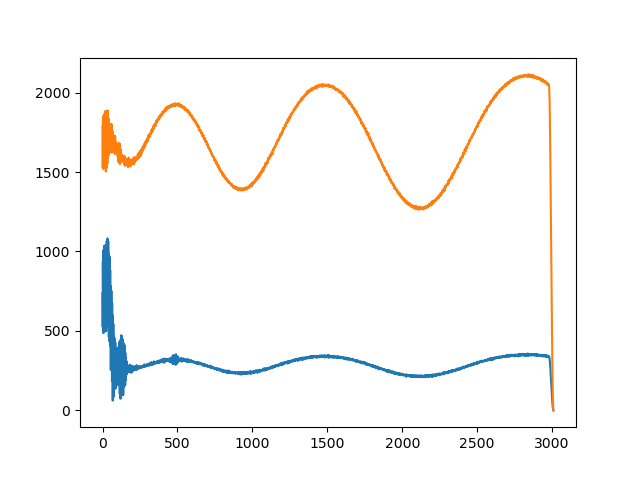

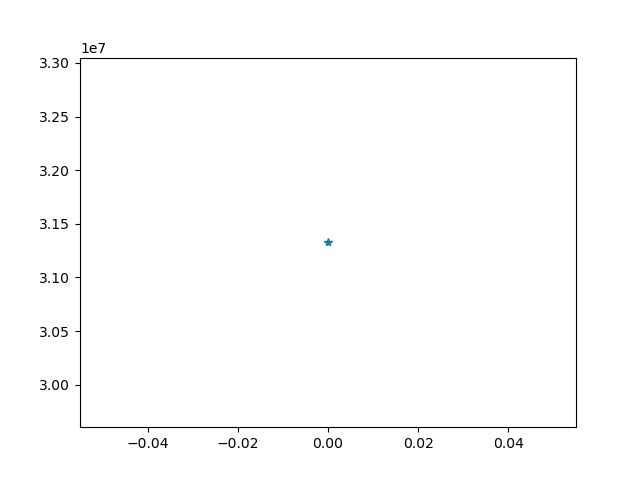

In [39]:
## TODO (IDEA): PCA sniffer coils before weighting and subtracting from k-space to "denoise" them. Compare SNR with and without.

from scipy.sparse.linalg import svds
from scipy.linalg import svd
U, S, V = svds(ksp_sniffer.reshape((ksp_sniffer.shape[0]*ksp_sniffer.shape[1], -1)), k=1)
ksp_sniffer2 = (U@np.diag(S))@V
ksp_sniffer2 = ksp_sniffer2.reshape((ksp_sniffer.shape[0], ksp_sniffer.shape[1], ksp_sniffer.shape[2]))
plt.figure()
plt.plot(np.sort(S), "*")
plt.figure()
plt.plot(np.abs(ksp_measured[:,0,0].squeeze()))
plt.plot(np.abs(ksp_sniffer2[:,0,0].squeeze()))
plt.show()

In [40]:
import time
import multiprocessing as mp

# ===============================================================
# Prepare EDITER weights and inputs
# ===============================================================
start_time = time.time()

# emi_hat = np.zeros(ksp_measured.shape, dtype=np.complex64)


dk = [3, 0]

w = np.concatenate((np.zeros((pre_discard, coord.shape[2])), np.sqrt(coord[0,:,:]**2 + coord[1,:,:]**2))).astype(np.float32)
n_pe = round(1000 / hdr.sequenceParameters.TR[0])  # 4 * Nlines / Nrep

editer_params = {
    'grouping_method': "uniform",  # "uniform", "corr_orig"
    'max_lines_per_group': n_pe,   # Max number of lines in a group
    'dk': dk                     # Convolution kernel size in kx and ky directions 
}

chs = range(ksp_measured.shape[2])

def process_channel(ch):
    est_emi_ch, _ = apply_editer(ksp_measured[:, :, ch], ksp_sniffer2, editer_params, w)
    return est_emi_ch

# results = [process_channel(ch_i) for ch_i in chs] # Single process for dbg
with mp.Pool(processes=len(chs)) as pool:
    results = pool.map(process_channel, chs)


emi_hat = np.stack(results, axis=2)
ksp_emicorr = ksp_measured - emi_hat

print(f"Elapsed time: {time.time() - start_time} seconds")



Elapsed time: 348.99671030044556 seconds


## Profiler

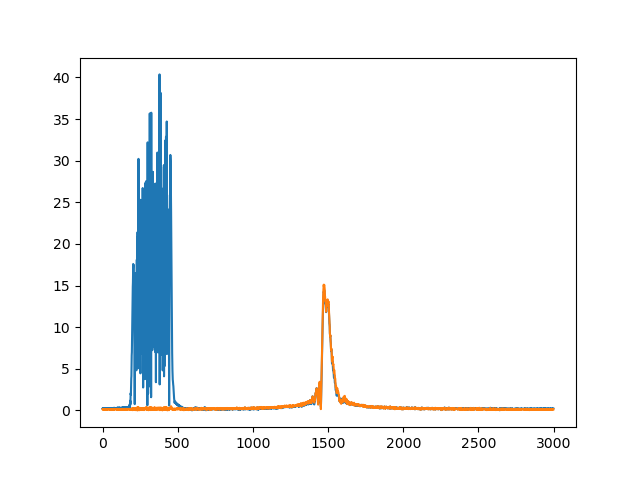

In [41]:
# %load_ext line_profiler
# %lprun -u 1 -f est_emi apply_editer(ksp_measured[:, :, 0], ksp_sniffer, editer_params, w)

plt.figure()
plt.plot(np.abs(to_hybrid_kspace(ksp_measured[pre_discard:,0,0])))
plt.plot(np.abs(to_hybrid_kspace(ksp_emicorr[pre_discard:,0,0])))


# Create a new MRD dataset, use the original as a template, and write corrected k-space into it.

In [42]:
n_samp = ksp_emicorr.shape[0]

if remove_os:
    ksp_emicorr = pyfftw.byte_align(ksp_emicorr)

    keepOS = np.concatenate([np.arange(n_samp // 4), np.arange(n_samp * 3 // 4, n_samp)])
    ifft_ = pyfftw.builders.ifft(ksp_emicorr, n=n_samp, axis=0, threads=32, planner_effort='FFTW_ESTIMATE')
    # ksp_emicorr = ifft(ksp_emicorr, axis=0)
    ksp_emicorr = ifft_()

    fft_ = pyfftw.builders.fft(ksp_emicorr[keepOS, :, :], n=n_samp, axis=0, threads=32, planner_effort='FFTW_ESTIMATE')
    # ksp_emicorr = fft(ksp_emicorr[keepOS, :, :], axis=0)
    ksp_emicorr = fft_()
    n_samp = n_samp // 2


output_dir_fullpath = os.path.join(DATA_ROOT, DATA_DIR, 'raw', 'h5_proc')
output_data_fullpath = os.path.join(output_dir_fullpath, f'{raw_file_[:-3]}_editer.h5')
print('Saving to ' + output_data_fullpath)

Path.mkdir(Path(output_dir_fullpath), exist_ok=True)

# Add EDITER parameters to XML header.
new_hdr = copy.deepcopy(hdr)
new_hdr.userParameters.userParameterLong.append(ismrmrd.xsd.userParameterLongType('EDITER_kx', editer_params['dk'][0]))
new_hdr.userParameters.userParameterLong.append(ismrmrd.xsd.userParameterLongType('EDITER_ky', editer_params['dk'][1]))
new_hdr.userParameters.userParameterLong.append(ismrmrd.xsd.userParameterLongType('EDITER_maxNoLines', editer_params['max_lines_per_group']))
new_hdr.userParameters.userParameterString.append(ismrmrd.xsd.userParameterStringType('processing', 'EDITER'))
new_hdr.userParameters.userParameterString.append(ismrmrd.xsd.userParameterStringType('EDITER_groupingAlgo', editer_params['grouping_method']))
new_hdr.acquisitionSystemInformation.coilLabel = [hdr.acquisitionSystemInformation.coilLabel[ch_i] for ch_i in mri_coils]
new_hdr.acquisitionSystemInformation.receiverChannels = len(new_hdr.acquisitionSystemInformation.coilLabel)

# Copy and fix acquisition objects
new_acq_list = []

for acq_i, acq_ in enumerate(acq_list):
    new_head = copy.deepcopy(acq_.getHead())
    new_head.active_channels = len(new_hdr.acquisitionSystemInformation.coilLabel)
    new_head.available_channels = len(new_hdr.acquisitionSystemInformation.coilLabel)
    if remove_os:
        new_head.number_of_samples = ksp_emicorr.shape[0]
        new_head.center_sample = pre_discard//2

    new_acq_list.append(ismrmrd.Acquisition(head=new_head, data=np.ascontiguousarray(ksp_emicorr[:,acq_i,:].squeeze().T.astype(np.complex64))))

with ismrmrd.Dataset(output_data_fullpath, create_if_needed=True) as new_dset:
    for acq_ in new_acq_list:
        new_dset.append_acquisition(acq_)

    for wave_ in wf_list:
        new_dset.append_waveform(wave_)

    new_dset.write_xml_header(ismrmrd.xsd.ToXML(new_hdr))


Saving to /server/home/btasdelen/MRI_DATA/pilottone/vol0912_20240626/raw/h5_proc/meas_MID00292_FID16401_pulseq2D_fire_spiralga_1500mV_24MHz_editer.h5


/server/home/btasdelen/miniforge3/envs/pilottone/lib/python3.10/site-packages/h5py/_hl/filters.py:250: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  chunks = guess_chunk(shape, maxshape, dtype.itemsize)
